# Add flow

    syn to see what timing is --> CLOCK PERIOD
    power-rtl to generate checkpoint

    generate testbench (vectors, clock period)
    sim-rtl
    redo-power-rtl (load checkpoint)


In [132]:
import yaml
import os
import textwrap
import random
import matplotlib.pyplot as plt
import numpy as np
#from concurrent.futures import ThreadPoolExecutor

design='add8'
pdk='sky130'
# pdk='intech22'
tools='cm'

dut_instance='adder0'
root_dir=os.path.abspath(f"{os.getcwd()}/../")
build_dir=f"{root_dir}/build-{pdk}-{tools}/{design}"
out_dir=os.path.abspath(f"{os.getcwd()}/../../out")
jpower_reports_dir = f"{out_dir}/jpower-reports/{design}-{pdk}"
generated_src_dir = f"{root_dir}/generated-src"
generated_configs_dir = f"{root_dir}/generated-configs"
bsub="bsub -q normal"
overwrite=True

os.makedirs(generated_src_dir, exist_ok=True)
os.makedirs(generated_configs_dir, exist_ok=True)

## Useful Functions

In [192]:
def get_test_name(tb_name):
    args = tb_name.replace('_-','_n').split('-')
    in0_args = args[1].split('_')
    in1_args = args[2].split('_')
    in0_initial = in0_args[1].replace('n','-')
    in0 = in0_args[2].replace('n','-')
    in1_initial = in1_args[1].replace('n','-')
    in1 = in1_args[2].replace('n','-')
    ret = f"({in0_initial},{in1_initial}) -> ({in0} + {in1})"
    return ret

def generate_verilog_fanout(num_adders):
    def gen_verilog(in_vals, in_initial=(0,0), seed=10, CLOCK_PERIOD=1):
        in0_initial,in1_initial = in_initial
        in0,in1 = in_vals
        tb_name=f"add8-in0_{in0_initial}_{in0}-in1_{in1_initial}_{in1}_fanout{num_adders}"

        random.seed(seed)
        adder_ins = ""
        adder_outs = ""
        adders = ""
        in_fs = ""
        for i in range(num_adders):
            #adder_ins += f"reg [`WIDTH-1:0] in_f{i};\n                "
            adder_ins += f"reg [`WIDTH-1:0] in_f{i};\n{16*' '}"
            adder_outs += f"wire [`WIDTH-1:0] out_f{i};\n{16*' '}"
            adders += f"add8 add8_f{i} ( .clock(clk), .in0(out), .in1(in_f{i}), .out(out_f{i}) );\n{16*' '}"
            in_fs += f"in_f{i} = `WIDTH'd{abs(random.randint(0, 127))};\n{20*' '}" 

        verilog=f"""\
            `timescale 1ns/10ps
            
            `define WIDTH 8
            
            module add8_tb;
            
                reg clk = 0;
                always #({CLOCK_PERIOD}/2.0) clk = ~clk;
            
                reg [`WIDTH-1:0] in0, in1;
                wire [`WIDTH-1:0] out;
                // Generated adders' inputs and outputs: 
                {adder_ins}
                {adder_outs}
            
                add8 add8_dut ( .clock(clk), .in0(in0), .in1(in1), .out(out) );
                // Generated adders:
                {adders}
            
                initial begin
                    in0 = {'-' if in0_initial < 0 else ''}`WIDTH'd{abs(in0_initial)}; in1 = {'-' if in1_initial < 0 else ''}`WIDTH'd{abs(in1_initial)};
                    @(negedge clk);
                    $fsdbDumpfile("{tb_name}.fsdb"); 
                    $fsdbDumpvars("+all"); 
                    $fsdbDumpon;
                    in0 = {'-' if in0 < 0 else ''}`WIDTH'd{abs(in0)}; in1 = {'-' if in1 < 0 else ''}`WIDTH'd{abs(in1)}; 
                    {in_fs}
                    @(posedge clk);
                    @(negedge clk);
                    $fsdbDumpoff;
                    $finish;
                end
            endmodule 
            """

        with open(f"{generated_src_dir}/{tb_name}.v",'w') as f:
            f.write(textwrap.dedent(verilog))
        return tb_name
    return gen_verilog

def generate_verilog(in_vals, in_initial=(0,0), CLOCK_PERIOD=1):
    in0_initial,in1_initial = in_initial
    in0,in1 = in_vals
    tb_name=f"add8-in0_{in0_initial}_{in0}-in1_{in1_initial}_{in1}"
    verilog=f"""\
    `timescale 1ns/10ps

    `define WIDTH 8

    module add8_tb;

        reg clk = 0;
        always #({CLOCK_PERIOD}/2.0) clk = ~clk;

        reg [`WIDTH-1:0] in0, in1;
        wire [`WIDTH-1:0] out;

        add8 add8_dut ( .clock(clk), .in0(in0), .in1(in1), .out(out) );

        initial begin
            in0 = {'-' if in0_initial < 0 else ''}`WIDTH'd{abs(in0_initial)}; in1 = {'-' if in1_initial < 0 else ''}`WIDTH'd{abs(in1_initial)};
            @(negedge clk);
            $fsdbDumpfile("{tb_name}.fsdb"); 
            $fsdbDumpvars("+all"); 
            $fsdbDumpon;
            in0 = {'-' if in0 < 0 else ''}`WIDTH'd{abs(in0)}; in1 = {'-' if in1 < 0 else ''}`WIDTH'd{abs(in1)};
            @(posedge clk); 
            @(negedge clk);
            $fsdbDumpoff; 
            $finish;
        end
    endmodule
    """

    with open(f"{generated_src_dir}/{tb_name}.v",'w') as f:
        f.write(verilog)
    return tb_name

def generate_config(tb_name, adder_fanout, fanout_lim, fixed=False):
    waveform = ""
    if fixed == True:
        waveform = f"{root_dir}/build-{pdk}-{tools}/{design}-branch_0_to_{fanout_lim}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb"
    else:
        waveform = f"{root_dir}/build-{pdk}-{tools}/{design}-branch{adder_fanout}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb"

    cfg = {
        'vlsi.core.power_tool': "hammer.power.joules",

        'power.inputs':
        {
            'level': 'rtl',
            'input_files': ["src/add8.v"],
            'top_module': "add8",
            'tb_name': "add8_tb",
            'tb_dut': "add8_dut",
            'waveforms': [],
            # 'waveforms': ["build-intech22-cm/add8/sim-rtl-rundir/output.fsdb"],
            'report_configs':[
                {
                # 'waveform_path': f"{build_dir}/sim-rtl-rundir/{tb_name}.fsdb",
                #'waveform_path': f"{root_dir}/build-{pdk}-{tools}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb",
                #'waveform_path': f"{root_dir}/build-{pdk}-{tools}/{design}-branch{adder_fanout}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb",
                 'waveform_path': f"{waveform}",
                # 'interval_size': '0.5ns',
                'toggle_signal': 'clock',
                'num_toggles': 1,
                'report_name': tb_name,
                'output_formats': ['plot_profile', 'report']
                }
            ]
        },
        'power.inputs.power_spec': "auto",
        # sim clock has to match synthesized clock period
        'sim.inputs':
        {
            'input_files': ['src/add8.v', f'{generated_src_dir}/{tb_name}.v'],
            'defines': ["CLOCK_PERIOD=1"],
            'defines_meta': 'append',
            'options': ['-timescale=1ns/10ps'],
            'options_meta': 'append',
        },
        'vlsi.inputs.clocks': [
            {'name': "clock", 'period': "1ns", 'uncertainty': "10ps"}
        ]
    }
    with open(f"{generated_configs_dir}/{tb_name}.yml",'w') as f:
        yaml.dump(cfg,f,sort_keys=False)


In [94]:
# one-time design setup
print(f"""
make syn design={design} pdk={pdk} -B
make power-rtl design={design} pdk={pdk} -B
""")


make syn design=add8 pdk=sky130 -B
make power-rtl design=add8 pdk=sky130 -B



In [161]:
in0_initial=0
in1_initial=0
in0=7
in1=6

hammer_cmds_file = "hammer_cmds"
adder_fanout_num = 8
random.seed(10)

tests = []

def rand_pair():
    return (random.randint(-127,127),random.randint(-127,127))

def generate_rand_pairs():
    with open(f"{root_dir}/{hammer_cmds_file}",'w') as hammer_cmds:
        for in_data in [(0,0),(85,85),rand_pair(),rand_pair()]:
            for in_initial in [(0,0),(-86,-86),(-1,-1),rand_pair()]:
                #tb_name=generate_verilog(in_data,in_initial)
                tb_name=generate_verilog_fanout(adder_fanout_num)(in_data,in_initial, 10)
                generate_config(tb_name, adder_fanout_num)
                cmd = ""
                #fsdb_path = f"{root_dir}/build-{pdk}-{tools}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb"
                fsdb_path = f"{root_dir}/build-{pdk}-{tools}/{design}-branch{adder_fanout_num}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb"
                if overwrite or not os.path.exists(fsdb_path):
                    #cmd += f"""make sim-rtl design={design} pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml OBJ_DIR=build-{pdk}-{tools}/{tb_name}"""
                    cmd += f"""make sim-rtl design={design} pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml OBJ_DIR=build-{pdk}-{tools}/{design}-branch{adder_fanout_num}/{tb_name}"""
                rpt_path = f"{build_dir}/power-rtl-rundir/reports/{tb_name}.power.rpt"
                if overwrite or not os.path.exists(rpt_path):
                    if len(cmd) > 0: cmd += " && "
                    cmd += f"""make redo-power-rtl args="--only_step report_power" design={design} pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml """
                if len(cmd) > 0:
                    #print(f"{bsub} '{cmd}'")
                    print(cmd)
                    hammer_cmds.write(f"{cmd}\n")
                tests.append(tb_name)       

def generate_fixed(fixed_in_pair, fixed_initial_pair, fanout_lim):
    with open(f"{root_dir}/{hammer_cmds_file}",'w') as hammer_cmds:
        for i in range(fanout_lim):
            tb_name = generate_verilog_fanout(i)(fixed_in_pair, fixed_initial_pair)
            generate_config(tb_name, i, fanout_lim, fixed=True)
            cmd = ""
            fsdb_path = f"{root_dir}/build-{pdk}-{tools}/{design}-branch{adder_fanout_num}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb"
            if overwrite or not os.path.exists(fsdb_path):
                cmd += f"""make sim-rtl design={design} pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml OBJ_DIR=build-{pdk}-{tools}/{design}-branch_0_to_{fanout_lim}/{tb_name}"""
            rpt_path = f"{build_dir}/power-rtl-rundir/reports/{tb_name}.power.rpt"
            if overwrite or not os.path.exists(rpt_path):
                if len(cmd) > 0: cmd += " && "
                cmd += f"""make redo-power-rtl args="--only_step report_power" design={design} pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml """
            if len(cmd) > 0:
                print(cmd)
                hammer_cmds.write(f"{cmd}\n")
            tests.append(tb_name)       

## Select branching factor limit and the operands

In [162]:
lim = 8
initial_operands = (0, 127)
incoming_operands = (-128, 0)

## Generate configs and testbenches

In [193]:
generate_fixed(incoming_operands, initial_operands, lim)

make sim-rtl design=add8 pdk=sky130 POWER_CONF=/bwrcq/scratch/alexvolkov/energy-char/generated-configs/add8-in0_3_-100-in1_-1_100_fanout0.yml OBJ_DIR=build-sky130-cm/add8-branch_0_to_8/add8-in0_3_-100-in1_-1_100_fanout0 && make redo-power-rtl args="--only_step report_power" design=add8 pdk=sky130 POWER_CONF=/bwrcq/scratch/alexvolkov/energy-char/generated-configs/add8-in0_3_-100-in1_-1_100_fanout0.yml 
make sim-rtl design=add8 pdk=sky130 POWER_CONF=/bwrcq/scratch/alexvolkov/energy-char/generated-configs/add8-in0_3_-100-in1_-1_100_fanout1.yml OBJ_DIR=build-sky130-cm/add8-branch_0_to_8/add8-in0_3_-100-in1_-1_100_fanout1 && make redo-power-rtl args="--only_step report_power" design=add8 pdk=sky130 POWER_CONF=/bwrcq/scratch/alexvolkov/energy-char/generated-configs/add8-in0_3_-100-in1_-1_100_fanout1.yml 
make sim-rtl design=add8 pdk=sky130 POWER_CONF=/bwrcq/scratch/alexvolkov/energy-char/generated-configs/add8-in0_3_-100-in1_-1_100_fanout2.yml OBJ_DIR=build-sky130-cm/add8-branch_0_to_8/add8-

In [ ]:
# Parallelize

#hmr_cmd = []
#with open(f"{root_dir}/{hammer_cmds_file}", 'r') as hammer_cmds:
#    hmr_cmd = hammer_cmds.readlines()
#hmr_cmd
#notebook_dir = os.getcwd()
#os.chdir(root_dir)
#with ThreadPoolExecutor() as exec:
#    exec.map(os.system, hmr_cmd)
#os.chdir(notebook_dir)

## Displaying results

In [ ]:
tests_dict = {t: {} for t in tests}
tests_dict

In [166]:
### area
with open(f"{build_dir}/syn-rundir/reports/final_area.rpt",'r') as f:
    for line in f.readlines():
        if line.strip().startswith(dut_instance) and len(line.split())==6:
            words = line.split()
            cell_count=int(words[2])
            area=float(words[-1])

cell_count,area

(35, 447.367)

In [171]:
### avg power
# todo: generate this earlier when generating joules yaml file
for tb_name in tests_dict:
    power_rpt_fpath = f"{build_dir}/power-rtl-rundir/reports/{tb_name}.hier.power.rpt"
    if not os.path.exists(power_rpt_fpath):
        print(power_rpt_fpath)
        continue
    with open(power_rpt_fpath,'r') as f:
        for line in f.readlines():
            if line.strip().endswith(f"/{design}/{dut_instance}") and len(line.split())==8:
                words = line.split()
                tests_dict[tb_name]['leakage_power'] = float(words[2])*1000
                tests_dict[tb_name]['internal_power'] = float(words[3])*1000
                tests_dict[tb_name]['switching_power'] = float(words[4])*1000
                tests_dict[tb_name]['total_power'] = float(words[5])*1000

# leakage_power, internal_power, switching_power, total_power

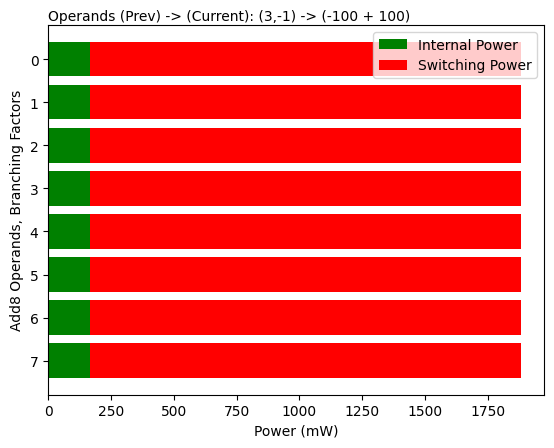

In [172]:
tests_sorted = [t for _,t in sorted([(tests_dict[t]['total_power'],t) for t in tests_dict if 'total_power' in tests_dict[t]])]
power_sorted = [tests_dict[t]['total_power'] for t in tests_sorted]
switching = [tests_dict[t]['switching_power'] for t in tests_sorted]
internal = [tests_dict[t]['internal_power'] for t in tests_sorted]
names = list(map(get_test_name,tests_sorted))

names2 = [t[-1] for t in tests_sorted]

fig, ax = plt.subplots()

y_pos = np.arange(len(names2))

# ax.barh(y_pos, power_sorted, align='center')
ax.barh(y_pos, internal, align='center', color='g', label='Internal Power')
ax.barh(y_pos, switching, left=internal, align='center', color='r', label='Switching Power')
ax.set_yticks(y_pos, labels=names2)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Power (mW)')
ax.set_ylabel(f'Add8 Operands, Branching Factors')
plt.legend()
test_name = list(map(get_test_name, tests_sorted))[0]
tb_name = f"Operands (Prev) -> (Current): {test_name}"
plt.text(-0.1,-1,tb_name,horizontalalignment='left',verticalalignment='center')
plt.savefig(f"{root_dir}/build-{pdk}-{tools}/{design}-branch_0_to_{fanout_limit}/{design}-branch_0_to_{fanout_limit}.png",bbox_inches='tight')